<a href="https://colab.research.google.com/github/rajeshwarihebballi/embryoClassification/blob/main/embryo_Classification_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Embryo classification based on microscopic images  

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
pip install tabulate

# Table of Contents
<a id="toc"></a>
- [1. Import Libraries](#1)
- [2. Read Dataset](#2)
- [3. Visualization](#3)
- [4. Preprocessing](#4)
- [5. Modeling](#5)
- [6. Predict test data](#6)
- [7. Submission](#7)   

<a id="1"></a>
# **<center><span style="color:#005dc4;">Import Libraries</span></center>**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Data preparation
ROOT_PATH = "/content/drive/MyDrive/hvwc23/"
train_df = pd.read_csv(f'{ROOT_PATH}/train.csv')
train_df['path'] = ROOT_PATH + 'train/' + train_df['Image']

In [ ]:
print(train_df.shape)

(840, 3)


[716 124]


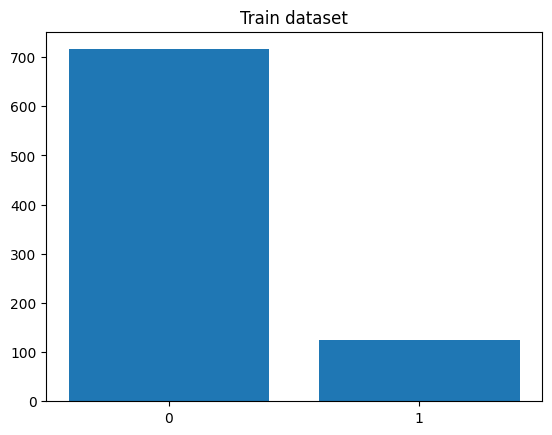

In [ ]:
# all data visualization
labels = train_df['Class'].value_counts()
plt.bar(['0','1'], labels.values)
print(labels.values)
plt.title('Train dataset')
plt.show()

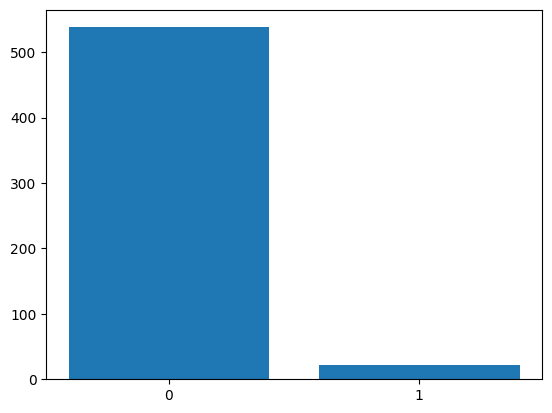

[538  22]


In [ ]:

# contain D3 images
D3 = train_df['Image'].apply(lambda x: 'D3_' in x)
labels = train_df[D3]['Class'].value_counts()
plt.bar(['0','1'], labels.values)
plt.show()
print(labels.values)

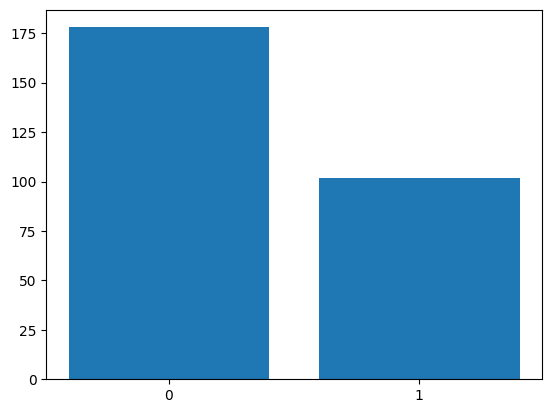

[178 102]


In [ ]:


# contain D5 images
D5 = train_df['Image'].apply(lambda x: 'D5_' in x)
labels = train_df[D5]['Class'].value_counts()
plt.bar(['0','1'], labels.values)
plt.show()
print(labels.values)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import KFold, train_test_split
import os

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
ROOT_PATH = "/content/drive/MyDrive/hvwc23/"
data_df = pd.read_csv(f'{ROOT_PATH}/train.csv')
data_df['path'] = ROOT_PATH + 'train/' + data_df['Image']

# Splitting data into training and testing
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Define the CNN model class
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)

    def forward(self, x):
        return self.base_model(x)

# Function to preprocess images
def preprocess_jpeg(jpeg_path):
    img = cv2.imread(jpeg_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return transforms.ToTensor()(img)

# Custom Dataset class
class EmbryoData(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['path']
        image = preprocess_jpeg(img_path)
        label = self.dataframe.iloc[index]['Class']
        return image, label, self.dataframe.iloc[index]['Image']

# Training function with K-Fold Cross-Validation
def train_kfold(num_epochs=3, num_folds=5):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    best_accuracy = 0
    best_model_state = None

    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_df)):
        print(f'FOLD {fold}')
        train_sub = train_df.iloc[train_ids]
        val_sub = train_df.iloc[val_ids]

        train_dataset = EmbryoData(train_sub)
        val_dataset = EmbryoData(val_sub)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        model = CNNModel().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        for epoch in range(num_epochs):
            model.train()
            for images, labels, _ in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validate after every fold
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = model.state_dict()
            print(f'New best model found at Fold {fold} with accuracy {accuracy}%')

    print(f'Best Validation Accuracy: {best_accuracy}%')
    return best_model_state

# Define a function to make predictions with the best model and save the results
def predict_and_save_results(model_state_path, dataframe, output_csv_path):
    if not os.path.exists(model_state_path):
        print("Model state file not found.")
        return

    model = CNNModel().to(device)
    model.load_state_dict(torch.load(model_state_path))
    model.eval()

    dataset = EmbryoData(dataframe)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    image_ids = []
    predictions = []
    with torch.no_grad():
        for images, labels, ids in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            image_ids.extend(ids)
            predictions.extend(predicted.cpu().numpy())

    results_df = pd.DataFrame({
        'Image': image_ids,
        'Predicted_Class': predictions
    })
    results_df.to_csv(output_csv_path, index=False)
    print(f"Predicted results saved to '{output_csv_path}'.")

# Run the training and get the best model state
best_model_state = train_kfold(3, 5)
torch.save(best_model_state, 'best_trained_model.pth')
print("Best model saved as 'best_trained_model.pth'.")

# Run the final prediction on the test dataset and save the results
best_model_path = 'best_trained_model.pth'
results_csv_path = 'test_prediction_results.csv'
predict_and_save_results(best_model_path, test_df, results_csv_path)


FOLD 0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.0MB/s]


New best model found at Fold 0 with accuracy 91.85185185185185%
FOLD 1
FOLD 2
FOLD 3
FOLD 4
Best Validation Accuracy: 91.85185185185185%
Best model saved as 'best_trained_model.pth'.
Predicted results saved to 'test_prediction_results.csv'.


In [ ]:
!pip install streamlit
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
!pip install pandas matplotlib

In [ ]:
%%writefile app.py
import streamlit as st
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import torch.nn as nn

# Define the CNN model class as used previously
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)

    def forward(self, x):
        return self.base_model(x)

# Load the saved models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_trained_model.pth'))

# Define preprocessing for uploaded images
def preprocess_jpeg(jpeg_path):
    img = cv2.imread(jpeg_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return transforms.ToTensor()(img).unsqueeze(0).to(device)

# Prediction function
def predict_image(image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
    return predicted.item()

# Streamlit interface
st.title('Embryo Image Classification Dashboard')
uploaded_file = st.file_uploader("Choose an embryo image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image_path = f"temp_image.{uploaded_file.type.split('/')[1]}"
    with open(image_path, "wb") as f:
        f.write(uploaded_file.getbuffer())
    st.image(image_path, caption='Uploaded Image.', use_column_width=True)
    image_tensor = preprocess_jpeg(image_path)
    if st.button('Predict'):
        prediction = predict_image(image_tensor)
        st.write("Prediction: **{}**".format("Good Embryo" if prediction == 1 else "Bad Embryo"))


Writing app.py


In [ ]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [ ]:
from pyngrok import conf, ngrok
conf.get_default().auth_token = "2h4hbPVDmJS0hVW7L9iQdVq1U8z_5QmSJVh92beD8waPCG9UM"

In [ ]:
!streamlit run app.py &>/dev/null&
public_url = ngrok.connect(8501, "http")
print(public_url)

NgrokTunnel: "https://6ec7-34-19-50-197.ngrok-free.app" -> "http://localhost:8501"
